<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/perfect_model/notebooks/CNN_Transfer_Learning_Improved_Explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b perfect_model https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


# Emotion Classification with Transfer Learning (Improved)

This notebook improves your previous pipeline with:
- Two-stage fine-tuning (head-only warmup, then full unfreeze)
- Better learning rate scheduling (Linear warmup + Cosine)
- Stable mixed precision (no deprecation warnings)
- Early stopping + EMA (Exponential Moving Average)
- Clear, per-epoch logging including LR, losses, accuracy, macro F1
- Robust evaluation: Confusion Matrix + Classification Report (Validation & Test)
- Explainability: Grad-CAM/Grad-CAM++ (updated API), SHAP (DeepExplainer), LIME
- Safe checkpoint loading for PyTorch 2.6 (weights_only change)
- ONNX export and quick verification via ONNX Runtime

Tips:
- Confirm data CSV paths in the config cell.
- If you have a larger GPU, you can raise `batch_size`.
- You can switch backbones (resnet50 by default) to ConvNeXt/EfficientNet/ViT (requires `timm`).


In [2]:
# If running on a fresh Colab, uncomment to install packages
%pip install -U timm grad-cam shap lime onnx onnxruntime opencv-python seaborn scikit-learn

In [3]:
from __future__ import annotations
import os, gc, json, math, time, random, pathlib
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, List, Dict, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import timm
    TIMM_AVAILABLE = True
except Exception:
    TIMM_AVAILABLE = False

# Explainability & Export
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap
from lime import lime_image
import onnx, onnxruntime as ort
import cv2

## Config
- Update the paths below to point to your CSVs.
- `model_type`: choose 'resnet50' (default) or any timm model like 'convnext_base', 'tf_efficientnet_b3_ns', 'vit_base_patch16_224'.
- `freeze_backbone_epochs`: head-only warmup epochs, then full unfreeze.

In [4]:
@dataclass
class CFG:
    # Paths (update as needed)
    project_root: Path = Path('/content/ann-visual-emotion')
    csv_train: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv')
    csv_val:   Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv')
    csv_test:  Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv')
    label_map_json: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json')
    out_dir: Path = Path('/content/ann-visual-emotion/artifacts_explainability')

    image_col: str = 'path'
    label_col: str = 'label'

    # Backbone
    model_type: str = 'resnet50'  # try: 'convnext_base', 'tf_efficientnet_b3_ns', 'vit_base_patch16_224'
    pretrained: bool = True
    img_size: int = 224

    # Optimization
    batch_size: int = 32
    epochs: int = 60
    freeze_backbone_epochs: int = 3  # head-only warmup
    lr_backbone: float = 1e-4
    lr_head: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05
    use_amp: bool = True
    grad_clip_norm: float = 1.0

    # Regularization
    use_mixup: bool = True
    mixup_alpha: float = 0.4
    use_cutmix: bool = False
    cutmix_alpha: float = 1.0

    # Early stopping
    patience: int = 12
    monitor: str = 'macro_f1'  # or 'acc'

    # EMA
    use_ema: bool = True
    ema_decay: float = 0.999

    # Class weighting / sampler
    use_class_weights: bool = True
    use_weighted_sampler: bool = False
    class_weight_alpha: float = 0.6

    # Explainability toggles
    run_gradcam: bool = True
    run_gradcam_pp: bool = True
    run_shap: bool = True
    run_lime: bool = True
    run_vit_attn: bool = True  # only if model_type startswith('vit')

    # ONNX export
    export_onnx: bool = True
    onnx_filename: str = 'best_model.onnx'

    seed: int = 42

cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)
print(cfg)

CFG(project_root=PosixPath('/content/ann-visual-emotion'), csv_train=PosixPath('/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv'), csv_val=PosixPath('/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv'), csv_test=PosixPath('/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv'), label_map_json=PosixPath('/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json'), out_dir=PosixPath('/content/ann-visual-emotion/artifacts_explainability'), image_col='path', label_col='label', model_type='resnet50', pretrained=True, img_size=224, batch_size=32, epochs=60, freeze_backbone_epochs=3, lr_backbone=0.0001, lr_head=0.001, weight_decay=0.0001, label_smoothing=0.05, use_amp=True, grad_clip_norm=1.0, use_mixup=True, mixup_alpha=0.4, use_cutmix=False, cutmix_alpha=1.0, patience=12, monitor='macro_f1', use_ema=True, ema_decay=0.999, use_class_weights=True, use_weighted_sampler=False, class_weight_alpha=0.6, run_gradcam=True, run_gradcam_pp=T

In [5]:
# Utils & setup
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def check_paths():
    print('Project root:', cfg.project_root)
    for p in [cfg.csv_train, cfg.csv_val, cfg.csv_test, cfg.label_map_json]:
        print(f'{p}: {"OK" if Path(p).exists() else "MISSING"}')

check_paths()

train_df = pd.read_csv(cfg.csv_train)
val_df   = pd.read_csv(cfg.csv_val)
test_df  = pd.read_csv(cfg.csv_test)

def load_label_map(path: Path, df: pd.DataFrame, label_col: str) -> Tuple[List[str], Dict[str,int]]:
    if path.exists():
        with open(path, 'r') as f:
            lm = json.load(f)
        label_to_id = {k: int(v) for k,v in lm.items()}
    else:
        unique = sorted(df[label_col].unique().tolist())
        label_to_id = {lbl: i for i, lbl in enumerate(unique)}
    classes = [lbl for lbl, _id in sorted(label_to_id.items(), key=lambda x: x[1])]
    return classes, label_to_id

CLASSES, class_to_idx = load_label_map(cfg.label_map_json, train_df, cfg.label_col)
NUM_CLASSES = len(CLASSES)
print('Classes:', CLASSES)
print('Train counts:', train_df[cfg.label_col].value_counts().to_dict())

Device: cuda
Project root: /content/ann-visual-emotion
/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json: OK
Classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Train counts: {'surprised': 9394, 'fearful': 9394, 'angry': 9393, 'happy': 9359, 'sad': 9359, 'neutral': 9359}


## Transforms & Dataset
- Strong but safe augmentations for train, deterministic center crop for val/test.
- Optionally enable weighted sampler (dataset is near-balanced).

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def build_transforms(img_size):
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.25, 0.25, 0.25, 0.10),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms(cfg.img_size)

class EmotionDataset(Dataset):
    def __init__(self, df, image_col, label_col, class_to_idx, transform=None, root: Optional[Path]=None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.root = Path(root) if root else cfg.project_root

    def resolve_path(self, raw):
        p = Path(raw)
        if p.is_absolute() and p.exists(): return p
        try:
            candidate = self.root / p.relative_to('/')
        except Exception:
            candidate = self.root / p
        if candidate.exists(): return candidate
        if p.exists(): return p
        raise FileNotFoundError(f'Image not found: {raw}')

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = self.resolve_path(row[self.image_col])
        label_name = row[self.label_col]
        label = self.class_to_idx[label_name]
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            if self.transform:
                img = self.transform(img)
        return img, label, str(img_path)

train_dataset = EmotionDataset(train_df, cfg.image_col, cfg.label_col, class_to_idx, transform=train_tf)
val_dataset   = EmotionDataset(val_df,   cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)
test_dataset  = EmotionDataset(test_df,  cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)

# Class weights
counts = train_df[cfg.label_col].value_counts().reindex(CLASSES).values.astype(float)
if cfg.use_class_weights:
    inv = 1.0 / (counts ** cfg.class_weight_alpha)
    class_weights = inv / inv.sum() * len(CLASSES)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
else:
    class_weights_tensor = torch.ones(NUM_CLASSES, dtype=torch.float32).to(device)

if cfg.use_weighted_sampler:
    sample_weights = train_df[cfg.label_col].map({c: class_weights[i] for i,c in enumerate(CLASSES)}).values
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights), num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
len(train_dataset), len(val_dataset), len(test_dataset)

(56258, 12056, 12056)

## Build Model
- Choose the backbone via `cfg.model_type`.
- Two param-groups: backbone LR vs head LR for discriminative fine-tuning.

In [7]:
def build_resnet50(num_classes, pretrained=True):
    m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    feat = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Linear(feat, 512), nn.ReLU(inplace=True), nn.LayerNorm(512), nn.Dropout(0.25),
        nn.Linear(512, num_classes)
    )
    return m

def build_timm(model_name: str, num_classes: int, pretrained=True):
    assert TIMM_AVAILABLE, 'timm is required for this model.'
    return timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)

if cfg.model_type == 'resnet50':
    model = build_resnet50(NUM_CLASSES, pretrained=cfg.pretrained)
elif TIMM_AVAILABLE:
    model = build_timm(cfg.model_type, NUM_CLASSES, pretrained=cfg.pretrained)
else:
    raise ValueError('Unsupported model type without timm installed.')

model = model.to(device)

def make_param_groups(model, lr_backbone, lr_head):
    backbone_params, head_params = [], []
    # Heuristic head module names:
    head_names = ['fc', 'classifier', 'head', 'heads', 'last_layer', 'pre_logits', 'head_drop']
    head_modules = [getattr(model, hn) for hn in head_names if hasattr(model, hn)]
    head_param_ids = set()
    for hm in head_modules:
        for p in hm.parameters(): head_param_ids.add(id(p))
    for p in model.parameters():
        if id(p) in head_param_ids: head_params.append(p)
        else: backbone_params.append(p)
    return [
        {'params': backbone_params, 'lr': lr_backbone, 'base_lr': lr_backbone},
        {'params': head_params,     'lr': lr_head,     'base_lr': lr_head},
    ]

optimizer = torch.optim.AdamW(make_param_groups(model, cfg.lr_backbone, cfg.lr_head), weight_decay=cfg.weight_decay)
scaler = torch.amp.GradScaler('cuda', enabled=cfg.use_amp)

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1 - self.decay)
    def apply(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                p.data.copy_(self.shadow[n])

ema = EMA(model, decay=cfg.ema_decay) if cfg.use_ema else None

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=cfg.label_smoothing)

# LR schedulers: Linear warmup then Cosine decay
warmup_epochs = cfg.freeze_backbone_epochs
main_epochs = max(1, cfg.epochs - warmup_epochs)
warmup = LinearLR(optimizer, start_factor=0.2, total_iters=warmup_epochs) if warmup_epochs>0 else None
cosine = CosineAnnealingLR(optimizer, T_max=main_epochs)
if warmup:
    scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])
else:
    scheduler = cosine


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


## Training Utilities

In [8]:
def apply_mixup(x, y, alpha=0.4):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, (y, y[idx], lam), True

def apply_cutmix(x, y, alpha=1.0):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    rx, ry = np.random.randint(W), np.random.randint(H)
    rw = int(W * math.sqrt(1 - lam))
    rh = int(H * math.sqrt(1 - lam))
    x1, y1 = np.clip(rx - rw//2, 0, W), np.clip(ry - rh//2, 0, H)
    x2, y2 = np.clip(rx + rw//2, 0, W), np.clip(ry + rh//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adjust = 1 - ((x2 - x1)*(y2 - y1)/(W*H))
    return x, (y, y[idx], lam_adjust), True

def train_one_epoch(model, loader, optimizer, device, criterion, scaler=None):
    model.train()
    total_loss, total_correct, total = 0.0, 0.0, 0
    for imgs, labels, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        mixed = False
        if cfg.use_mixup and cfg.use_cutmix:
            if random.random() < 0.5:
                imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
            else:
                imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)
        elif cfg.use_mixup:
            imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
        elif cfg.use_cutmix:
            imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)

        with torch.amp.autocast('cuda', enabled=cfg.use_amp):
            logits = model(imgs)
            if mixed:
                loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb)
            else:
                loss = criterion(logits, labels)

        if scaler:
            scaler.scale(loss).backward()
            if cfg.grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            optimizer.step()

        if ema: ema.update(model)

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        if mixed:
            total_correct += (lam * preds.eq(ya).sum().item() + (1 - lam) * preds.eq(yb).sum().item())
        else:
            total_correct += preds.eq(labels).sum().item()
        total += bs

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0.0, 0
    all_preds, all_labels = [], []
    for imgs, labels, _ in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        total_correct += preds.eq(labels).sum().item()
        total += bs
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / total, acc, macro_f1, all_preds, all_labels

class EarlyStopper:
    def __init__(self, patience=10, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.bad = 0
        self.stop = False
    def step(self, val):
        if self.best is None:
            self.best = val
            return False
        improve = (val - self.best) if self.mode == 'max' else (self.best - val)
        if improve > self.min_delta:
            self.best = val; self.bad = 0
        else:
            self.bad += 1
        if self.bad >= self.patience:
            self.stop = True
        return self.stop


## Train (Two-Stage Fine-Tuning)
Stage 1: Train only the classification head (`freeze_backbone_epochs`).
Stage 2: Unfreeze all layers and continue training with discriminative LRs.

We print details per epoch: LRs of groups, Train/Val Loss, Acc, Macro F1. Best model by validation metric is saved.

Training resnet50 for 60 epochs...
Backbone frozen for 3 warmup epochs.
Epoch 01/60 | LRs: bb=0.000047, head=0.000467 | TrainLoss 1.6899 Acc 0.2897 | ValLoss 1.5647 Acc 0.3673 MacroF1 0.3423
Epoch 02/60 | LRs: bb=0.000073, head=0.000733 | TrainLoss 1.6656 Acc 0.3031 | ValLoss 1.5359 Acc 0.3816 MacroF1 0.3617


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 03/60 | LRs: bb=0.000100, head=0.001000 | TrainLoss 1.6593 Acc 0.3092 | ValLoss 1.5240 Acc 0.3907 MacroF1 0.3671
Unfroze backbone layers.
Epoch 04/60 | LRs: bb=0.000100, head=0.000999 | TrainLoss 1.4212 Acc 0.4580 | ValLoss 1.2901 Acc 0.5114 MacroF1 0.4793
Epoch 05/60 | LRs: bb=0.000100, head=0.000997 | TrainLoss 1.3364 Acc 0.5074 | ValLoss 1.1188 Acc 0.5959 MacroF1 0.5895
Epoch 06/60 | LRs: bb=0.000099, head=0.000993 | TrainLoss 1.2806 Acc 0.5383 | ValLoss 1.0195 Acc 0.6516 MacroF1 0.6547
Epoch 07/60 | LRs: bb=0.000099, head=0.000988 | TrainLoss 1.2533 Acc 0.5550 | ValLoss 0.9715 Acc 0.6734 MacroF1 0.6750
Epoch 08/60 | LRs: bb=0.000098, head=0.000981 | TrainLoss 1.2193 Acc 0.5724 | ValLoss 0.9917 Acc 0.6666 MacroF1 0.6703
Epoch 09/60 | LRs: bb=0.000097, head=0.000973 | TrainLoss 1.2075 Acc 0.5798 | ValLoss 0.9506 Acc 0.6887 MacroF1 0.6884
Epoch 10/60 | LRs: bb=0.000096, head=0.000963 | TrainLoss 1.1811 Acc 0.5942 | ValLoss 0.9175 Acc 0.7021 MacroF1 0.7033
Epoch 11/60 | LRs: bb=0

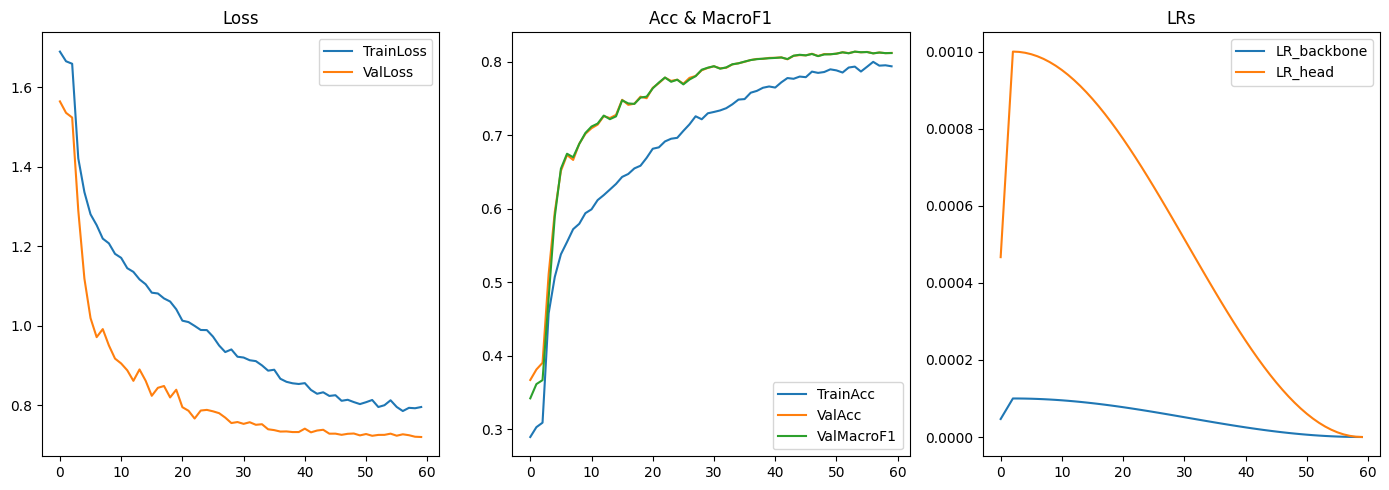

In [9]:
print(f'Training {cfg.model_type} for {cfg.epochs} epochs...')
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_macro_f1':[], 'lr_backbone':[], 'lr_head':[]}
early_stopper = EarlyStopper(patience=cfg.patience, mode='max')
best_metric, best_state = -1.0, None

# Stage 1: freeze backbone
if cfg.freeze_backbone_epochs > 0:
    for name, param in model.named_parameters():
        if 'fc' in name or 'classifier' in name or 'head' in name or 'heads' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
    print(f'Backbone frozen for {cfg.freeze_backbone_epochs} warmup epochs.')
else:
    print('No backbone freeze; training all layers from the start.')

for epoch in range(cfg.epochs):
    # Unfreeze all after warmup
    if epoch == cfg.freeze_backbone_epochs:
        for p in model.parameters(): p.requires_grad = True
        print('Unfroze backbone layers.')

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, criterion, scaler)
    if ema: ema.apply(model)
    val_loss, val_acc, val_macro_f1, val_preds, val_labels = evaluate(model, val_loader, device, criterion)

    # Step LR
    scheduler.step()

    # Log
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_macro_f1'].append(val_macro_f1)
    # capture group LRs
    if len(optimizer.param_groups) >= 2:
        history['lr_backbone'].append(optimizer.param_groups[0]['lr'])
        history['lr_head'].append(optimizer.param_groups[1]['lr'])
    else:
        history['lr_backbone'].append(optimizer.param_groups[0]['lr'])
        history['lr_head'].append(optimizer.param_groups[0]['lr'])

    metric_now = val_macro_f1 if cfg.monitor == 'macro_f1' else val_acc
    if metric_now > best_metric:
        best_metric = metric_now
        best_state = {'model': model.state_dict(), 'epoch': epoch, 'val_metric': best_metric, 'config': asdict(cfg)}
        torch.save(best_state, cfg.out_dir / 'best_model.pth')

    print(f"Epoch {epoch+1:02d}/{cfg.epochs} | LRs: bb={history['lr_backbone'][-1]:.6f}, head={history['lr_head'][-1]:.6f} | "
          f"TrainLoss {train_loss:.4f} Acc {train_acc:.4f} | ValLoss {val_loss:.4f} Acc {val_acc:.4f} MacroF1 {val_macro_f1:.4f}")

    if early_stopper.step(metric_now):
        print('Early stopping triggered.')
        break

print(f'Best {cfg.monitor} = {best_metric:.6f}')

# Curves
plt.figure(figsize=(14,5))
plt.subplot(1,3,1); plt.plot(history['train_loss'], label='TrainLoss'); plt.plot(history['val_loss'], label='ValLoss'); plt.legend(); plt.title('Loss')
plt.subplot(1,3,2); plt.plot(history['train_acc'], label='TrainAcc'); plt.plot(history['val_acc'], label='ValAcc'); plt.plot(history['val_macro_f1'], label='ValMacroF1'); plt.legend(); plt.title('Acc & MacroF1')
plt.subplot(1,3,3); plt.plot(history['lr_backbone'], label='LR_backbone'); plt.plot(history['lr_head'], label='LR_head'); plt.legend(); plt.title('LRs')
plt.tight_layout(); plt.show()

## Validation: Confusion Matrix + Classification Report (Best Checkpoint)
PyTorch 2.6 note: `torch.load` default `weights_only=True`. We explicitly set `weights_only=False` to load our dict with metadata safely (we created it in this notebook). Only do this for checkpoints you trust.

Validation (Best) Loss 0.7243 Acc 0.8140 MacroF1 0.8143

Validation Classification Report:
               precision    recall  f1-score   support

       angry     0.7919    0.8013    0.7965      2013
     fearful     0.7502    0.7894    0.7693      2013
       happy     0.9281    0.9138    0.9209      2006
     neutral     0.7525    0.7810    0.7665      2005
         sad     0.7727    0.7218    0.7464      2006
   surprised     0.8955    0.8768    0.8860      2013

    accuracy                         0.8140     12056
   macro avg     0.8151    0.8140    0.8143     12056
weighted avg     0.8151    0.8140    0.8143     12056



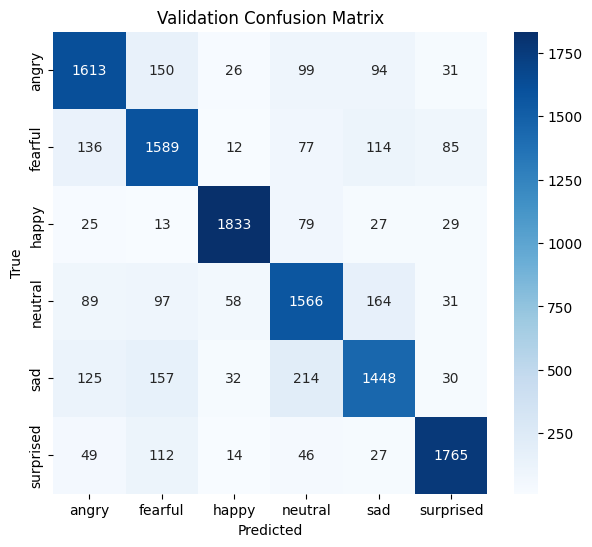

In [10]:
# Safe load (we created this checkpoint)
ckpt = torch.load(cfg.out_dir / 'best_model.pth', map_location=device, weights_only=False)
model.load_state_dict(ckpt['model'])
if ema: ema.apply(model)
model.eval()

val_loss, val_acc, val_macro_f1, val_preds, val_labels = evaluate(model, val_loader, device, criterion)
print(f'Validation (Best) Loss {val_loss:.4f} Acc {val_acc:.4f} MacroF1 {val_macro_f1:.4f}')
print('\nValidation Classification Report:\n', classification_report(val_labels, val_preds, target_names=CLASSES, digits=4))

cm_v = confusion_matrix(val_labels, val_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Validation Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## Test Evaluation: Confusion Matrix + Classification Report

Test Loss 0.7164 Acc 0.8145 MacroF1 0.8149

Test Classification Report:
               precision    recall  f1-score   support

       angry     0.8041    0.7890    0.7965      2014
     fearful     0.7402    0.7700    0.7548      2013
       happy     0.9366    0.9142    0.9253      2005
     neutral     0.7570    0.8076    0.7815      2006
         sad     0.7798    0.7332    0.7558      2005
   surprised     0.8772    0.8733    0.8753      2013

    accuracy                         0.8145     12056
   macro avg     0.8158    0.8145    0.8149     12056
weighted avg     0.8158    0.8145    0.8148     12056



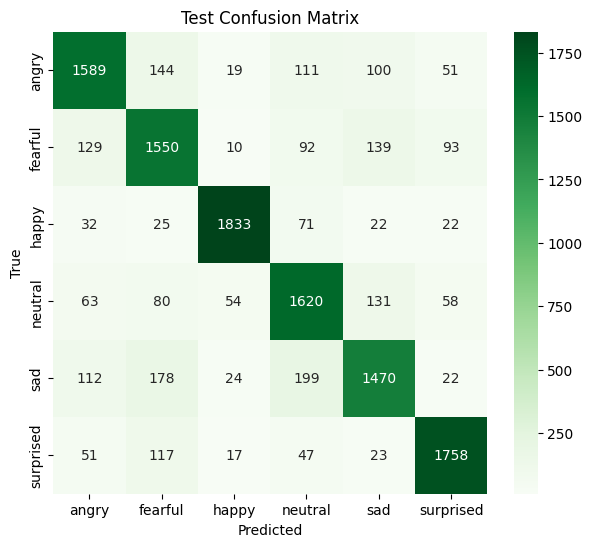

In [11]:
test_loss, test_acc, test_macro_f1, test_preds, test_labels = evaluate(model, test_loader, device, criterion)
print(f'Test Loss {test_loss:.4f} Acc {test_acc:.4f} MacroF1 {test_macro_f1:.4f}')
print('\nTest Classification Report:\n', classification_report(test_labels, test_preds, target_names=CLASSES, digits=4))

cm_t = confusion_matrix(test_labels, test_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm_t, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Test Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

## Grad-CAM / Grad-CAM++
Updated for current `pytorch-grad-cam` API (no `use_cuda` arg).


Grad-CAM visualizations:


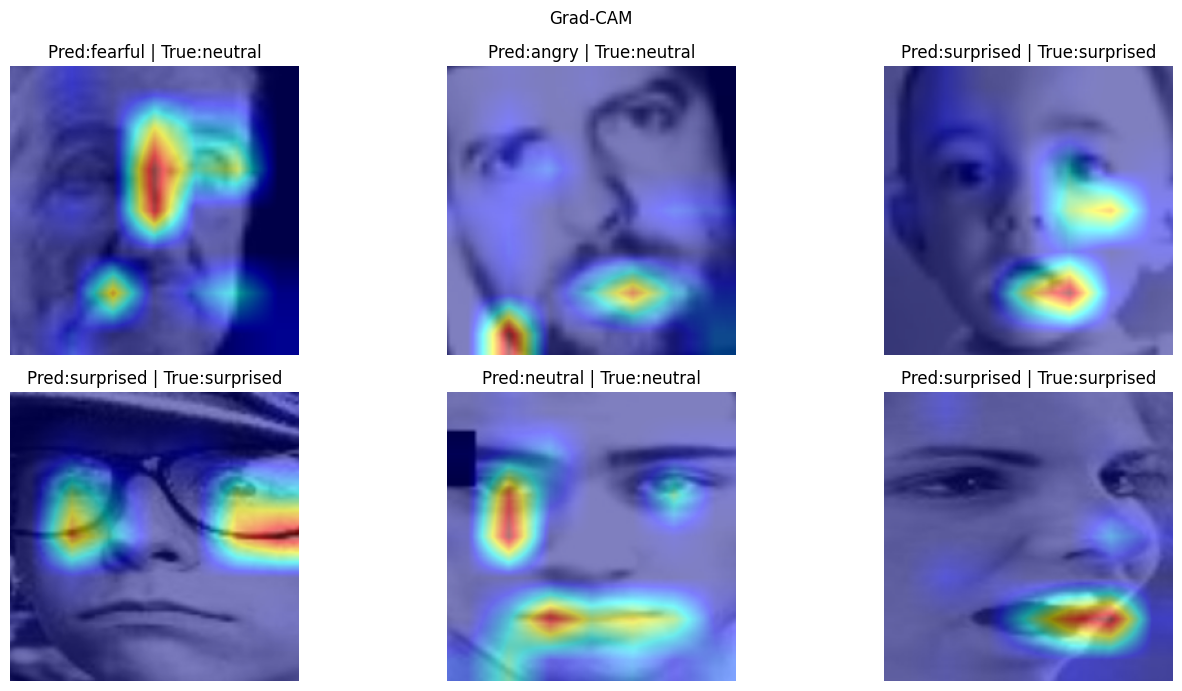


Grad-CAM++ visualizations:


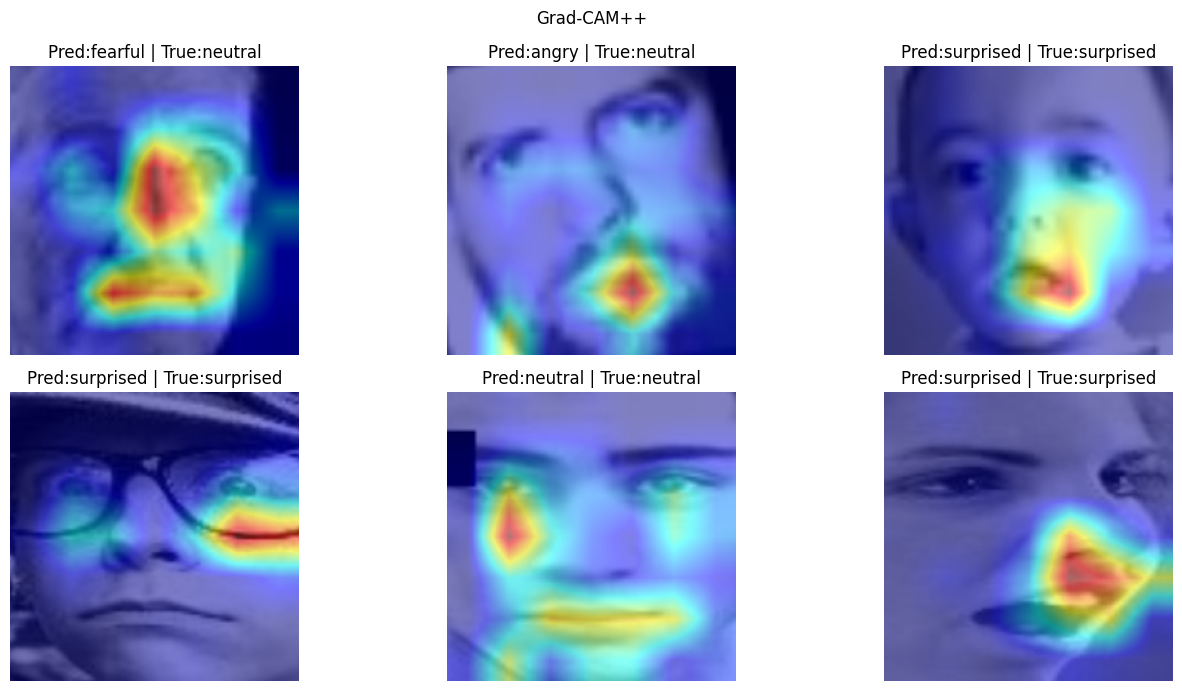

In [12]:
def tensor_to_rgb(img_t: torch.Tensor):
    # img_t: 1x3xHxW normalized tensor
    x = img_t.squeeze(0).detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN))
    x = np.clip(x, 0, 1)
    return x

def select_target_layers_for_cam(model):
    if cfg.model_type == 'resnet50':
        return [model.layer4[-1]]
    elif cfg.model_type.startswith('vit') and hasattr(model, 'blocks'):
        return [model.blocks[-1].norm1] if hasattr(model.blocks[-1], 'norm1') else [model.blocks[-1]]
    else:
        # try to find last conv
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, nn.Conv2d): return [module]
        raise ValueError('No suitable CAM layer found.')

if cfg.run_gradcam or cfg.run_gradcam_pp:
    imgs_vis, labels_vis = [], []
    for i in range(min(6, len(test_dataset))):
        img, lab, _ = test_dataset[i]
        imgs_vis.append(img); labels_vis.append(lab)
    imgs_vis_t = torch.stack(imgs_vis).to(device)
    target_layers = select_target_layers_for_cam(model)

    model.eval()
    with torch.no_grad():
        logits = model(imgs_vis_t)
        preds = logits.argmax(1).cpu().numpy()

    cam_methods = []
    if cfg.run_gradcam: cam_methods.append(('Grad-CAM', GradCAM))
    if cfg.run_gradcam_pp: cam_methods.append(('Grad-CAM++', GradCAMPlusPlus))

    for cam_name, CamClass in cam_methods:
        cam = CamClass(model=model, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=imgs_vis_t)  # [N, H, W]
        print(f'\n{cam_name} visualizations:')
        plt.figure(figsize=(14,7))
        for i in range(len(imgs_vis)):
            rgb = tensor_to_rgb(imgs_vis[i].unsqueeze(0))
            grad_cam_map = grayscale_cam[i]
            vis = show_cam_on_image(rgb, grad_cam_map, use_rgb=True)
            plt.subplot(2, 3, i+1)
            plt.imshow(vis)
            plt.axis('off')
            plt.title(f'Pred:{CLASSES[preds[i]]} | True:{CLASSES[labels_vis[i]]}')
        plt.suptitle(cam_name)
        plt.tight_layout(); plt.show()

## SHAP (DeepExplainer)
We use a small background set for speed. DeepExplainer supports PyTorch models directly.

In [13]:
if cfg.run_shap:
    print('Running SHAP (small subset for speed)...')
    # background tensors (normalized already)
    bg_idx = np.random.choice(len(train_dataset), size=min(16, len(train_dataset)), replace=False)
    bg_tensors = torch.stack([train_dataset[i][0] for i in bg_idx], dim=0).to(device)

    # small test batch
    test_idx = np.random.choice(len(test_dataset), size=min(4, len(test_dataset)), replace=False)
    test_tensors = torch.stack([test_dataset[i][0] for i in test_idx], dim=0).to(device)

    model.eval()
    explainer = shap.DeepExplainer(model, bg_tensors)
    shap_vals = explainer.shap_values(test_tensors)  # list of [C x N x 3 x H x W]

    # For each sample, pick predicted class and show mean |SHAP| overlay
    with torch.no_grad():
        logits = model(test_tensors)
        preds = logits.argmax(1).cpu().numpy()
    test_np = test_tensors.detach().cpu().numpy()

    for i in range(test_np.shape[0]):
        pc = preds[i]
        sv_c = shap_vals[pc][i]  # [3, H, W]
        sv_gray = np.mean(np.abs(sv_c), axis=0)
        img = np.transpose(test_np[i], (1,2,0))
        img = (img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN))
        img = np.clip(img, 0, 1)
        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title(f'Pred: {CLASSES[pc]}')
        plt.subplot(1,2,2); plt.imshow(sv_gray, cmap='seismic'); plt.colorbar(); plt.axis('off'); plt.title('SHAP |abs|')
        plt.tight_layout(); plt.show()

Running SHAP (small subset for speed)...


RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

## LIME (small subset)
Model-agnostic local explanations on a few samples.

In [ ]:
if cfg.run_lime:
    print('Running LIME (small subset for speed)...')
    explainer = lime_image.LimeImageExplainer()

    def predict_fn_for_explain(x: np.ndarray) -> np.ndarray:
        # x: N,H,W,3 uint8 or float [0..255]
        xs = []
        for i in range(x.shape[0]):
            img = x[i].astype(np.float32)
            if img.max() > 1.5: img = img / 255.0
            img_t = torch.tensor(np.transpose(img, (2,0,1)), dtype=torch.float32)
            # normalize
            for c in range(3):
                img_t[c] = (img_t[c] - IMAGENET_MEAN[c]) / IMAGENET_STD[c]
            xs.append(img_t)
        xs = torch.stack(xs).to(device)
        with torch.no_grad():
            logits = model(xs)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        return probs

    lime_idx = np.random.choice(len(test_dataset), size=min(4, len(test_dataset)), replace=False)
    for idx in lime_idx:
        img_t, _, _ = test_dataset[idx]
        img = np.transpose(img_t.numpy(), (1,2,0))
        img_rgb = (np.clip((img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)), 0, 1) * 255).astype(np.uint8)
        explanation = explainer.explain_instance(
            image=img_rgb,
            classifier_fn=predict_fn_for_explain,
            top_labels=1,
            hide_color=0,
            num_samples=600
        )
        top = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(label=top, positive_only=True, num_features=6, hide_rest=False)
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')
        plt.subplot(1,2,2); plt.imshow(temp); plt.axis('off'); plt.title(f'LIME Top: {CLASSES[top]}')
        plt.tight_layout(); plt.show()

## ONNX Export + Runtime Check

In [ ]:
if cfg.export_onnx:
    model.eval()
    onnx_path = cfg.out_dir / cfg.onnx_filename
    dummy = torch.randn(1, 3, cfg.img_size, cfg.img_size, device=device)
    dynamic_axes = {'input': {0: 'batch'}, 'logits': {0: 'batch'}}
    torch.onnx.export(
        model, dummy, str(onnx_path), input_names=['input'], output_names=['logits'],
        dynamic_axes=dynamic_axes, opset_version=17, do_constant_folding=True
    )
    print('Saved ONNX to:', onnx_path)
    sess = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
    out = sess.run(None, {'input': dummy.detach().cpu().numpy().astype(np.float32)})
    print('ONNXRuntime output shape:', out[0].shape)